### High-dimensional inference ###

Embedded regularization worked really well for us for selecting features in a (semi-)automated sense. We still needed to be careful when it came to selecting tuning parameter(s) and we have seen that selection can be quite unstable in the presence of noise(weak signal) and correlated features.

In addition, because selection is baked into the procedure it is not straightforward to obtain p-values for the estimated parameters. 

In this lecture we explore some re-sampling based methods as well as de-biasing approaches. 

Let's work with the heart disease data to make the demonstration easy to follow. Note, however, that this is not very high-dimensional per-se. We will use an extended version of the data set with extra noise features below. 

In [ ]:
######
#install.packages("ElemStatLearn")
#install.packages("bestglm")
#library(ElemStatLearn)
library(glmnet)
library(bestglm)
data(SAheart)
SAheart$famhist<-as.numeric(SAheart$famhist)
SAheart[,-10]<-as.matrix(SAheart[,-10])
######
mm <- glm(chd~.,data=SAheart,family="binomial") # the unconstrained logistic regression fit
summary(mm) # which feature coefficients are significant?

Installing package into ‘/home/johan/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



Warning message:
“package ‘ElemStatLearn’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Loading required package: leaps




Call:
glm(formula = chd ~ ., family = "binomial", data = SAheart)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7781  -0.8213  -0.4387   0.8889   2.5435  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.0760913  1.3404862  -5.279  1.3e-07 ***
sbp          0.0065040  0.0057304   1.135 0.256374    
tobacco      0.0793764  0.0266028   2.984 0.002847 ** 
ldl          0.1739239  0.0596617   2.915 0.003555 ** 
adiposity    0.0185866  0.0292894   0.635 0.525700    
famhist      0.9253704  0.2278940   4.061  4.9e-05 ***
typea        0.0395950  0.0123202   3.214 0.001310 ** 
obesity     -0.0629099  0.0442477  -1.422 0.155095    
alcohol      0.0001217  0.0044832   0.027 0.978350    
age          0.0452253  0.0121298   3.728 0.000193 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 596.11  on 461  degrees of freedom
Residual deviance: 

Let's use lasso to select feature for this data set and select $\lambda$ via cross-validation.

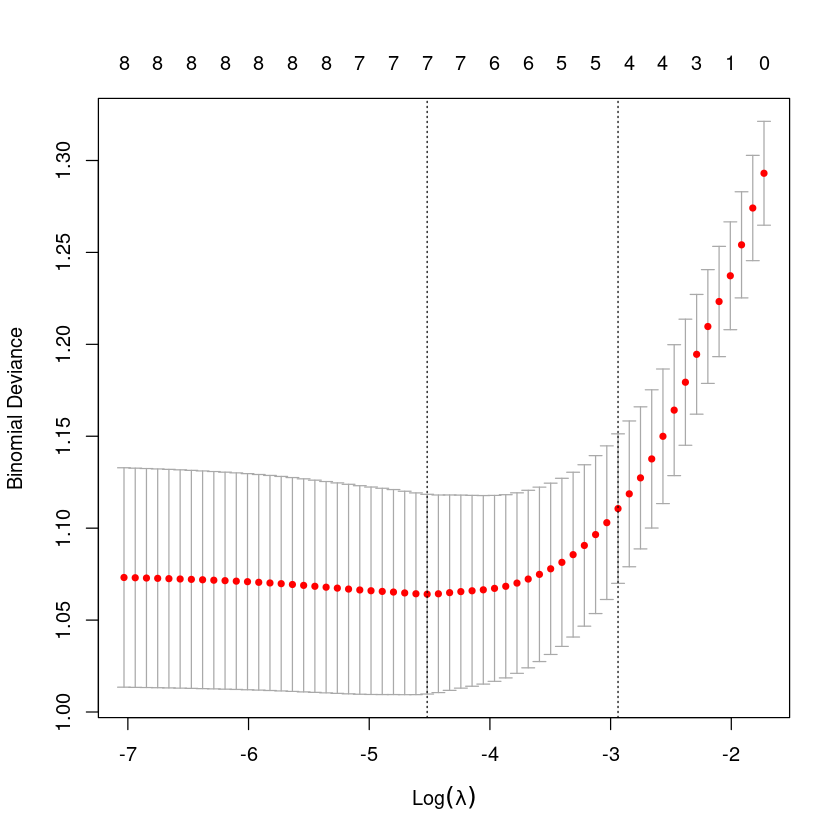

In [ ]:
gg.cv <- cv.glmnet(as.matrix(SAheart[,-10]),SAheart[,10],family="binomial") # fit a logistic regression model to the data
           # use cross-validation to select the regularzation parameter
plot(gg.cv)

We can now refit the selected model to the data using the optimal $\lambda$ from the cross-validation.

Is this OK? We are using the data for two purposes now: selection and validation(inference). We can get overly optimistic p-values for the selected features (somewhat compensated for a less complex model fit, but the p-values are not valid).

In [25]:
gg <- glmnet(as.matrix(SAheart[,-10]),SAheart[,10],family="binomial", lambda=gg.cv$lambda.1se)
whichsel <- (as.matrix(gg$beta)!=0)
whichsel
XM <- as.matrix((SAheart[,-10])[,whichsel])
dd <- data.frame(cbind(XM,SAheart$chd))
names(dd)<-c(names(SAheart[,-10])[whichsel],"chd")
mmg <- glm(chd~.,data=dd,family="binomial")
summary(mmg)

,s0
sbp,FALSE
tobacco,TRUE
ldl,TRUE
adiposity,FALSE
famhist,TRUE
typea,TRUE
obesity,FALSE
alcohol,FALSE
age,TRUE



Call:
glm(formula = chd ~ ., family = "binomial", data = dd)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9165  -0.8054  -0.4430   0.9329   2.6139  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.35462    0.96804  -7.597 3.02e-14 ***
tobacco      0.08038    0.02588   3.106  0.00190 ** 
ldl          0.16199    0.05497   2.947  0.00321 ** 
famhist      0.90818    0.22576   4.023 5.75e-05 ***
typea        0.03712    0.01217   3.051  0.00228 ** 
age          0.05046    0.01021   4.944 7.65e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 596.11  on 461  degrees of freedom
Residual deviance: 475.69  on 456  degrees of freedom
AIC: 487.69

Number of Fisher Scoring iterations: 5


#### Simple splitting strategy ####

What if we split the data in 2 and use one half for training and selection (via cross-validation) and the other half for validating the selected model. 

There are two main advantages to this
- we now have valid p-values
- we only need to correct the obtained p-values for the number of features in the selected model from the training data

,s0
sbp,FALSE
tobacco,FALSE
ldl,FALSE
adiposity,FALSE
famhist,TRUE
typea,FALSE
obesity,FALSE
alcohol,FALSE
age,TRUE



Call:
glm(formula = chd ~ ., family = "binomial", data = dd)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4557  -0.9027  -0.5566   1.0871   2.2130  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.03132    0.69245  -5.822 5.82e-09 ***
famhist      0.92540    0.30056   3.079 0.002078 ** 
age          0.04398    0.01133   3.883 0.000103 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 292.66  on 230  degrees of freedom
Residual deviance: 261.24  on 228  degrees of freedom
AIC: 267.24

Number of Fisher Scoring iterations: 4


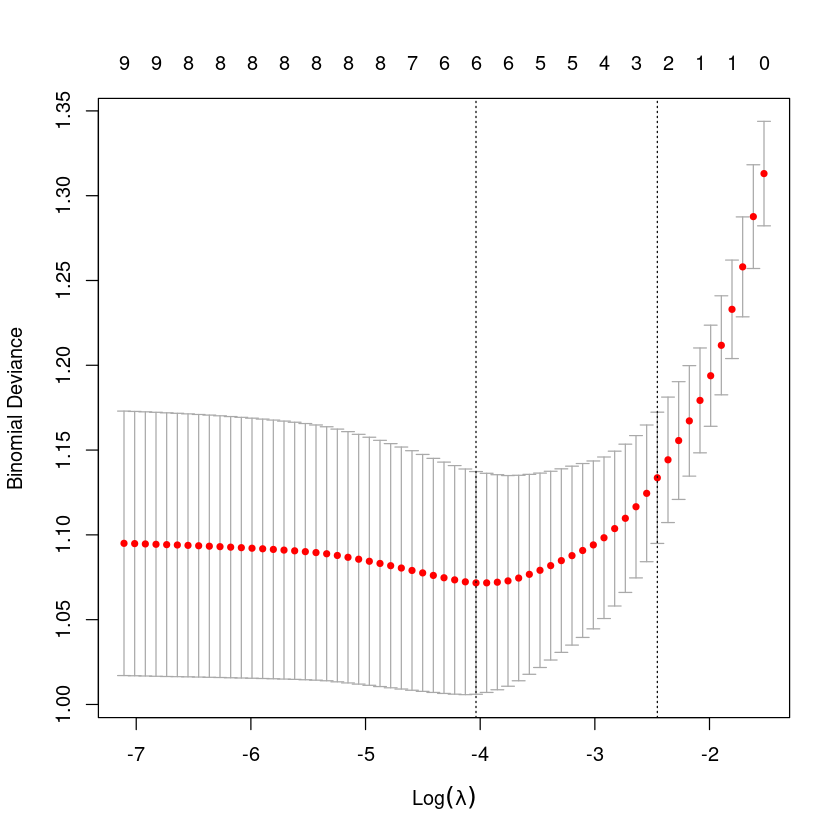

In [47]:
# Splitting procedure

nsamp <- dim(SAheart)[1]
i1 <- sample(seq(1,nsamp),floor(nsamp/2)) # train and select on this
i2 <- (seq(1,nsamp))[-i1]           # p-values and confidence intervals from this
###
gg.cv <- cv.glmnet(as.matrix(SAheart[i1,-10]),SAheart[i1,10],family="binomial")
plot(gg.cv)
#
gg <- glmnet(as.matrix(SAheart[i1,-10]),SAheart[i1,10],family="binomial", lambda=gg.cv$lambda.1se)
whichsel <- (as.matrix(gg$beta)!=0)
whichsel
#
XM <- as.matrix((SAheart[i2,-10])[,whichsel]) #  split 2
dd <- data.frame(cbind(XM,SAheart$chd[i2]))
names(dd)<-c(names(SAheart[,-10])[whichsel],"chd")
mmg <- glm(chd~.,data=dd,family="binomial")
summary(mmg)

However - there is also a drawback. If you run the above code cell a couple of times you may see that the results may differ both in terms of p-values but even which features appear among the selected ones that we get p-values for! (remember to remove the set.seed)

What should we do?

#### Multi-splitting strategy ####

Re-sampling to the rescue! 

Let's just run the simple splitting strategy several times, each time recording the p-value on the test set.

In [48]:
#Splitting procedure - repeated
B <- 250
pvalMat <- matrix(1,B,dim(SAheart)[2]-1) # if not selected, the p-value is 1 since the coefficient value is explicitly 0
#
for (bb in (1:B)) {
 nsamp <- dim(SAheart)[1]
 i1 <- sample(seq(1,nsamp),floor(nsamp/2)) # train and select on this
 i2 <- sample(seq(1,nsamp))[-i1]           # p-values and confidence intervals from this
 ###
 gg.cv <- cv.glmnet(as.matrix(SAheart[i1,-10]),SAheart[i1,10],family="binomial")
 #
 gg <- glmnet(as.matrix(SAheart[i1,-10]),SAheart[i1,10],family="binomial", lambda=gg.cv$lambda.1se)
 whichsel <- (as.matrix(gg$beta)!=0)
 #
 XM <- as.matrix((SAheart[i2,-10])[,whichsel]) #  split 2
 dd <- data.frame(cbind(XM,SAheart$chd[i2]))
 names(dd)<-c(names(SAheart[,-10])[whichsel],"chd")
 mmg <- glm(chd~.,data=dd,family="binomial")
 smg <- summary(mmg)$coef[-1,4] # p-values except for the intercept 
 smg <- smg*sum(whichsel) # correct for multiple testing - just the selected features
 smg[smg > 1] <-1
 pvalMat[bb,whichsel]<-smg
}

Note, in each run I correct the p-values from the test set by the number of selected features from the training set.

Let's investigate what the p-values look like across the multiple runs.

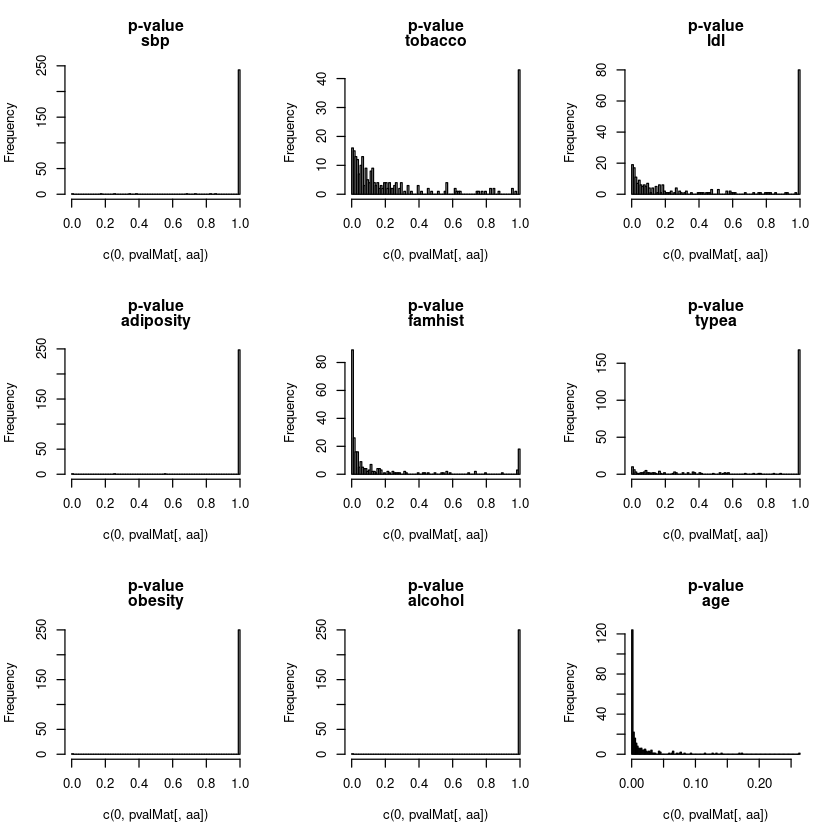

In [ ]:
par(mfrow=c(3,3)) 
for (aa in (1:dim(pvalMat)[2])) {
   hist(c(0,pvalMat[,aa]),breaks=100,main=paste(c("p-value",(names(SAheart)[-10])[aa]))) }
    # add an extra 0 just for visualization if all p-values are 1

As you can see, for some feauters the p-values are essentially always 1 - this is because they are never (rarely) selected. For other features you see p-values away from 1 but with a subset of runs (where the feature was not selected) where the p-value is 1.

This is tricky to aggregate. 

One possibility is to use a summary statistic like the median (or some other quantile) p-value from the multiple runs. We have to be a bit careful since the data splits partially overlap between runs to the p-values are actually dependent. How to aggregate is discussed in the paper I posted. 

Here I illustrate with the median aggregate. 

In [ ]:
p.final <- apply(pvalMat,2,median)*2 # in the hdi package you can use optimal quantiles here for minimum p-values since
                                     # the histogram of p-values look very different from case-to-case 
p.final[p.final > 1] <-1 
     # The use of the factor 2 comes from accounting for dependency between the multiple splits of data
     # in a conservative fashion
p.raw <-summary(mm)$coef[-1,4]
p.b <- p.raw*dim(SAheart[,-10])[2]
p.b[p.b > 1] <- 1
pf <- data.frame(cbind(round(p.raw,4),round(p.b,4),round(p.final,4)))
names(pf)<-c("p.raw","p.Bonf","p.multi")
row.names(pf)<-names(SAheart[,-10])
pf

,p.raw,p.Bonf,p.multi
,<dbl>,<dbl>,<dbl>
sbp,0.2564,1.0000,1.0000
tobacco,0.0028,0.0256,0.2728
ldl,0.0036,0.0320,0.4622
adiposity,0.5257,1.0000,1.0000
famhist,0.0000,0.0004,0.0539
typea,0.0013,0.0118,1.0000
obesity,0.1551,1.0000,1.0000
alcohol,0.9784,1.0000,1.0000
age,0.0002,0.0017,0.0044


Let's compare with the package 'hdi' in R (I posted a link to the python package in the canvas module).

In [ ]:
#install.packages("hdi")
library(hdi)
phdi<-multi.split(x=as.matrix(SAheart[,-10]),y=SAheart[,10],return.nonaggr=T, fraction=.5, gamma=.5, B=250, 
                args.model.selector=list(family="binomial"))

ERROR: Error in library(hdi): there is no package called ‘hdi’


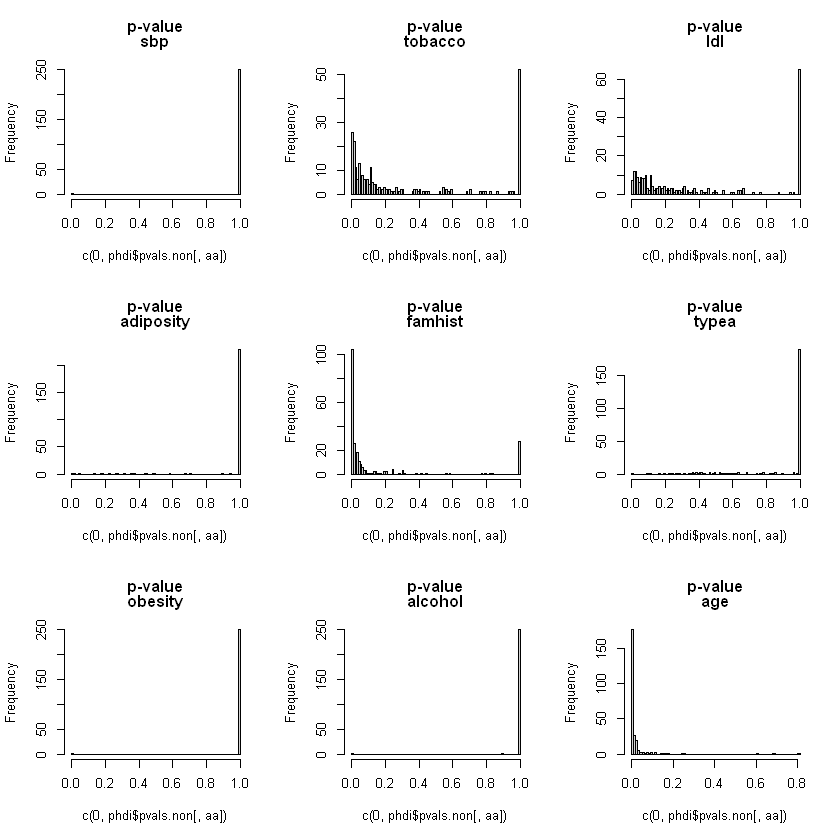

In [ ]:
par(mfrow=c(3,3))  # histograms of the non-aggregated corrected p-values
for (aa in (1:dim(phdi$pvals.non)[2])) {
   hist(c(0,phdi$pvals.non[,aa]),breaks=100,main=paste(c("p-value",(names(SAheart)[-10])[aa]))) } 
           # fudging adding a 0 for display purposes

In [ ]:
phdi.final <- apply(phdi$pvals.non,2,median)*2
phdi.final[phdi.final > 1] <- 1
pf <- data.frame(cbind(round(p.raw,4),round(p.b,4),round(p.final,4),round(phdi.final,4),round(phdi$pval.corr,4)))
names(pf)<-c("p.raw","p.Bonf","p.multi","p.hdi","p.hdi.corr")
row.names(pf)<-names(SAheart[,-10])
pf

,p.raw,p.Bonf,p.multi,p.hdi,p.hdi.corr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sbp,0.2564,1.0000,1.0000,1.0000,1.0000
tobacco,0.0028,0.0256,0.2728,0.2471,0.2471
ldl,0.0036,0.0320,0.4622,0.4335,0.4335
adiposity,0.5257,1.0000,1.0000,1.0000,1.0000
famhist,0.0000,0.0004,0.0539,0.0367,0.0367
typea,0.0013,0.0118,1.0000,1.0000,1.0000
obesity,0.1551,1.0000,1.0000,1.0000,1.0000
alcohol,0.9784,1.0000,1.0000,1.0000,1.0000
age,0.0002,0.0017,0.0044,0.0048,0.0048


The results are quite similar - some variability due to the sampling procedure is expected. 

The 'hdi' package has a built in tool for selecting the best quantile for p-value estimation for each feature. Try different number of runs $B$, splitting fractions between training and test, etc, at home.

In [ ]:
library(hdi)
phdi<-multi.split(x=as.matrix(SAheart[,-10]),y=SAheart[,10],return.nonaggr=T, B=250, 
                args.model.selector=list(family="binomial"))  # let hdi pick the best quantile 
phdi.final <- apply(phdi$pvals.non,2,median)*2
phdi.final[phdi.final > 1] <- 1
pf <- data.frame(cbind(round(p.raw,4),round(p.b,4),round(p.final,4),round(phdi.final,4),round(phdi$pval.corr,4)))
names(pf)<-c("p.raw","p.Bonf","p.multi","p.hdi - median","p.hdi.corr")
row.names(pf)<-names(SAheart[,-10])
pf
paste("optimal quantiles",phdi$gamma)

,p.raw,p.Bonf,p.multi,p.hdi - median,p.hdi.corr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sbp,0.2564,1.0000,1.0000,1.0000,1.0000
tobacco,0.0028,0.0256,0.2728,0.1737,0.3082
ldl,0.0036,0.0320,0.4622,0.5523,1.0000
adiposity,0.5257,1.0000,1.0000,1.0000,1.0000
famhist,0.0000,0.0004,0.0539,0.0319,0.0382
typea,0.0013,0.0118,1.0000,1.0000,1.0000
obesity,0.1551,1.0000,1.0000,1.0000,1.0000
alcohol,0.9784,1.0000,1.0000,1.0000,1.0000
age,0.0002,0.0017,0.0044,0.0070,0.0003


[1] "optimal quantiles 0.996" "optimal quantiles 0.116"
[3] "optimal quantiles 0.168" "optimal quantiles 0.996"
[5] "optimal quantiles 0.08"  "optimal quantiles 0.996"
[7] "optimal quantiles 0.996" "optimal quantiles 0.996"
[9] "optimal quantiles 0.052"

### Stability selection ### 

In class I talked about *stability selection*. This method, and variants thereof, is quite popular for e.g. large-scale network modeling using lasso-type methods. We will again use re-sampling to improve on the selection performance of the lasso.

This is not a p-value estimation method but an alternative to tuning parameter selection but with an eye on testing (false positives). 

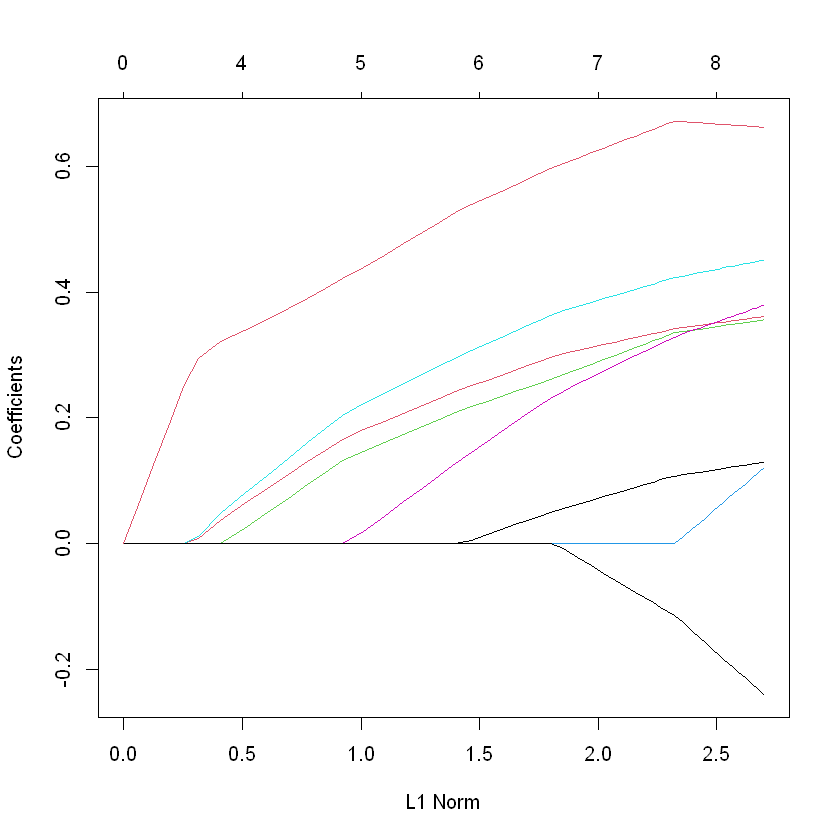

,s0
sbp,FALSE
tobacco,TRUE
ldl,TRUE
adiposity,FALSE
famhist,TRUE
typea,TRUE
obesity,FALSE
alcohol,FALSE
age,TRUE


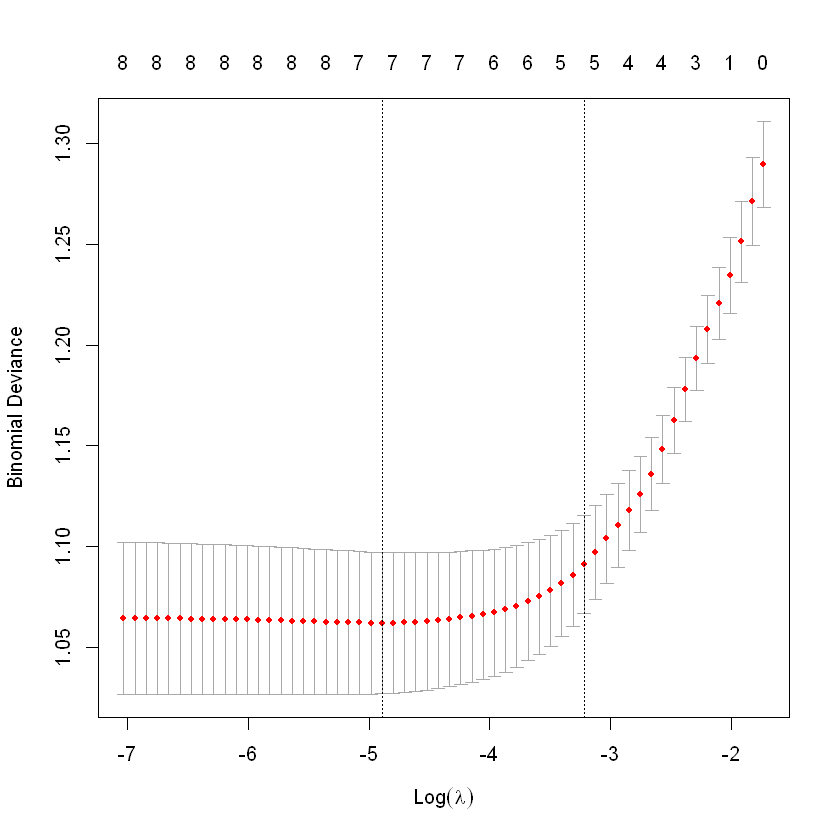

In [ ]:
standardize <- function(x) {(x-mean(x))/sd(x)}
SA <- SAheart
SA[,-10] <- apply(SA[,-10],2,standardize) # easier to plot solutions paths if standardized
#
gg <- glmnet(x=SA[,-10],y=SA[,10],family="binomial")
plot(gg)
gg.cv <- cv.glmnet(x=as.matrix(SA[,-10]),y=SA[,10],family="binomial")
plot(gg.cv)
gg <- glmnet(as.matrix(SAheart[,-10]),SAheart[,10],family="binomial", lambda=gg.cv$lambda.1se)
whichsel <- (as.matrix(gg$beta)!=0) 
whichsel
# 

I start by running lasso on the original data to illustrate the selection paths and the cross-validation errors.

It's not easy to see from the selection paths which $\lambda$ to select and you can see that the cross-validation error band is quite wide and the curve has a flat appearance - it's difficult to select the best amount of regularization here.

Does it matter? Isn't this one step removed from what we're after - the tuning parameter is a tool but it's the selection we're after. 

Let's try multiple splitting and check the proportion of times a feature is included in the model.

In [ ]:
gg <- glmnet(x=SA[,-10],y=SA[,10],family="binomial")
lamuse <- gg$lambda[gg$df<dim(SA[,-10])[2]-1] # use this grid for lambda
####
B <- 500
selMat <- matrix(0,length(lamuse),dim(SA)[2]-1) # add 1 each time for each lambda the feature is selected 
#
for (bb in (1:B)) {
 nsamp <- dim(SA)[1]
 i1 <- sample(seq(1,nsamp),floor(nsamp/2)) # train and select on this
 i2 <- sample(seq(1,nsamp))[-i1]    
 gg <- glmnet(x=SA[i1,-10],y=SA[i1,10],lambda=lamuse,family="binomial")
 for (ll in (1:length(lamuse))) {
    whichsel <- (as.matrix(gg$beta[,ll])!=0)
    selMat[ll,whichsel]<-selMat[ll,whichsel]+1/B }
    }

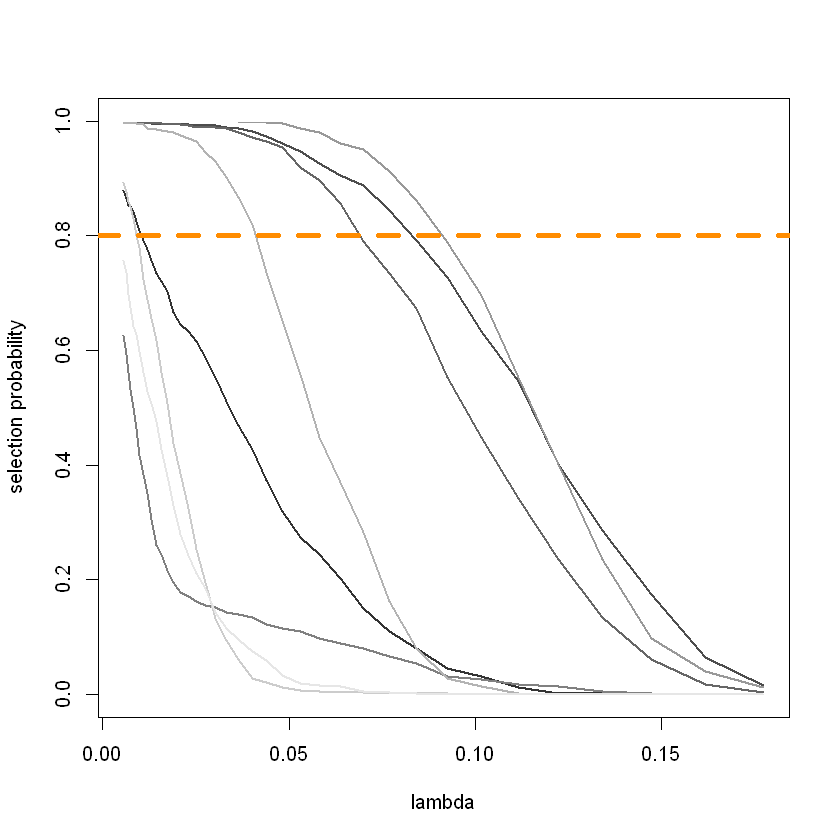

In [ ]:
for (aa in (1:dim(SA[,-10])[2])) {
   if (aa==1) {
       plot(lamuse,selMat[,aa],ylim=c(0,1),type="l",xlab="lambda",ylab="selection probability", 
            lwd=2, col=gray(.1+.9*aa/dim(SA[,-10])[2]))
   } 
   if (aa>1) {
       lines(lamuse,selMat[,aa],
             lwd=2, col=gray(.1+.9*aa/dim(SA[,-10])[2]))
             }   
}
abline(h=0.8, lty=2, col="darkorange",lwd=4)

The new path plot is called the *stability path*. On the y-axis is the selection probabilities (proportions) and we can now consider only keeping the features whose stability values exceed a threshold (here 0.8 drawn in the blot as a dashed line).

In the *Selection stability* paper (posted on canvas) the authors prove that we can control the expected number of falsely selected features by controling the threshold value and the range of the tuning parameter $\lambda$. They provide an explicit form for the relationship between the false positives, the  stability threshold and the $\lambda$ range.

In practice you might say that you believe the true model contains at most $\sim \sqrt(p)$ features. You can then choose a contraint on the number of false positives and this gives you the range of $\lambda$ to investigate or you can start with the range and work out the threshold.  This is all implemented in the 'stability' function in the 'hdi' package. 

In [ ]:
ql <- round(apply(selMat,1,sum),2) # average model size q(lambda) for each lambda
qL <- mean(apply(selMat,1,sum),2)  # across all lambda in search range
paste("average model size = ",qL) 
thresh <- 0.9
#
EV <- (qL^2/dim(SA[,-10])[2])/(2*thresh-1)
paste("threshold = ", thresh, " E(V) <= ", round(EV,4)) # too many false positives ?
# want at most 2
thresh <- 0.95
EV <- (qL^2/dim(SA[,-10])[2])/(2*thresh-1)
paste("threshold = ", thresh, " E(V) <= ", round(EV,4))
### you may have to adjust the range of lambda here
stab <- stability(x=SA[,-10],y=SA[,10], args.model.selector=list(family="binomial"), EV=2)
rbind(c("selected","threshold","q"), c(length(stab$selected),stab$threshold,stab$q))
stab$selected

[1] "average model size =  5.82"

[1] "threshold =  0.9  E(V) <=  4.7045"

[1] "threshold =  0.95  E(V) <=  4.1818"

selected,threshold,q
1,0.75,3


age 
  9

The method is geared toward high-dimensional settings so let's create a more challenging case from the heart disease data by adding some noise features.

In [ ]:
# More interesting with higher dimensional case
X <- matrix(rnorm(100*dim(SA)[1]),dim(SA)[1],100) # 100 extra null features
SA2 <- data.frame(cbind(SA,X))
names(SA2) <- c(names(SA),paste("X",seq(1,100),sep=""))
gg <- glmnet(x=SA2[,-10],y=SA2[,10],family="binomial")
#
lamuse <- gg$lambda[gg$df<(.5*dim(SA2[,-10])[2])] # use this grid for lambda 

In [ ]:
####
B <- 500
selMat <- matrix(0,length(lamuse),dim(SA2)[2]-1) # add 1 each time for each lambda the feature is selected 
#
for (bb in (1:B)) {
 nsamp <- dim(SA2)[1]
 i1 <- sample(seq(1,nsamp),floor(nsamp/2)) # train and select on this
 i2 <- sample(seq(1,nsamp))[-i1]    
 gg <- glmnet(x=SA2[i1,-10],y=SA2[i1,10],lambda=lamuse,family="binomial")
 for (ll in (1:length(lamuse))) {
    whichsel <- (as.matrix(gg$beta[,ll])!=0)
    selMat[ll,whichsel]<-selMat[ll,whichsel]+1/B }
    }

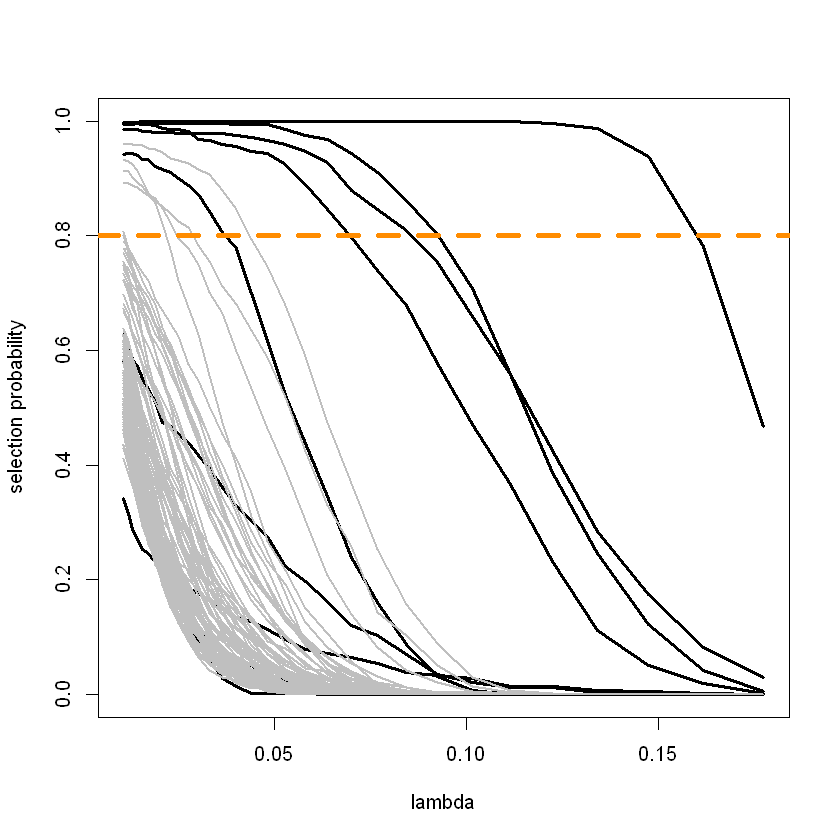

In [ ]:
for (aa in (1:dim(SA2[,-10])[2])) {
   if (aa==1) {
       plot(lamuse,selMat[,aa],ylim=c(0,1),type="l",xlab="lambda",ylab="selection probability", 
            lwd=3)
   } 
   if (aa>1 & aa<10) {
       lines(lamuse,selMat[,aa],
             lwd=3)
             } 
   if (aa>=10) {
       lines(lamuse,selMat[,aa],
             lwd=2, col=gray(.75))
             } 
    
}
abline(h=0.8, lty=2, col="darkorange",lwd=4)

The stability paths identify a few of the features are quite stable across a range of $\lambda$ and thresholds. Some of the original features are not reaching up to the threshold but this is expected from the orginal fit (check p-values at the top cell in the notebook).

Let's play with some contrainst on the false positives.

In [ ]:
ql <- round(apply(selMat,1,sum),2) # average model size q(lambda) for each lambda
qL <- mean(apply(selMat,1,sum),2)  # across all lambda in search range
paste("average model size = ",qL) 
thresh <- 0.75
EV <- (qL^2/dim(SA[,-10])[2])/(2*thresh-1)
paste("threshold = ", thresh, " E(V) <= ", round(EV,4)) # too many false positives ?
thp <- apply(selMat,2,max)
c("selected:", names(SA2[,-10])[thp>thresh])
# want at most 2
thresh <- 0.9
EV <- (qL^2/dim(SA[,-10])[2])/(2*thresh-1)
paste("threshold = ", thresh, " E(V) <= ", round(EV,4))
c("selected:", names(SA2[,-10])[thp>thresh])
# 
thresh <- 0.99
EV <- (qL^2/dim(SA[,-10])[2])/(2*thresh-1)
paste("threshold = ", thresh, " E(V) <= ", round(EV,4))
c("selected:", names(SA2[,-10])[thp>thresh])

[1] "average model size =  14.446"

[1] "threshold =  0.75  E(V) <=  46.3749"

[1] "selected:" "tobacco"   "ldl"       "famhist"   "typea"     "age"      
 [7] "X14"       "X19"       "X26"       "X29"       "X54"       "X56"      
[13] "X57"       "X63"       "X77"       "X90"       "X91"       "X95"

[1] "threshold =  0.9  E(V) <=  28.9843"

[1] "selected:" "tobacco"   "ldl"       "famhist"   "typea"     "age"      
[7] "X63"       "X77"       "X95"

[1] "threshold =  0.99  E(V) <=  23.6606"

[1] "selected:" "ldl"       "famhist"   "age"

To control the expected number of false positives around 25 we can us a threshold around 0.75.

In [ ]:
stab <- stability(x=SA2[,-10],y=SA2[,10], args.model.selector=list(family="binomial"), EV=25)
rbind(c("selected","threshold","q"), c(length(stab$selected),stab$threshold,stab$q))
stab$selected
####
stab <- stability(x=SA2[,-10],y=SA2[,10], args.model.selector=list(family="binomial"), EV=5)
rbind(c("selected","threshold","q"), c(length(stab$selected),stab$threshold,stab$q))
stab$selected

selected,threshold,q
8,0.75,37


tobacco     ldl famhist   typea     age     X54     X63     X95 
      2       3       5       6       9      63      72     104

selected,threshold,q
5,0.75,17


tobacco     ldl famhist     age     X63 
      2       3       5       9      72

Here you see that stability selection adjusts the range of $\lambda$ (q = average model size) to control EV. I used a fixed range in my code.

Let's run a recap of multiple testing on the expanded data set. 

In [ ]:
ll.spl <- multi.split(x=as.matrix(SA2[,-10]),y=SA2[,10],args.model.selector=list(family="binomial"))

[1] "age"

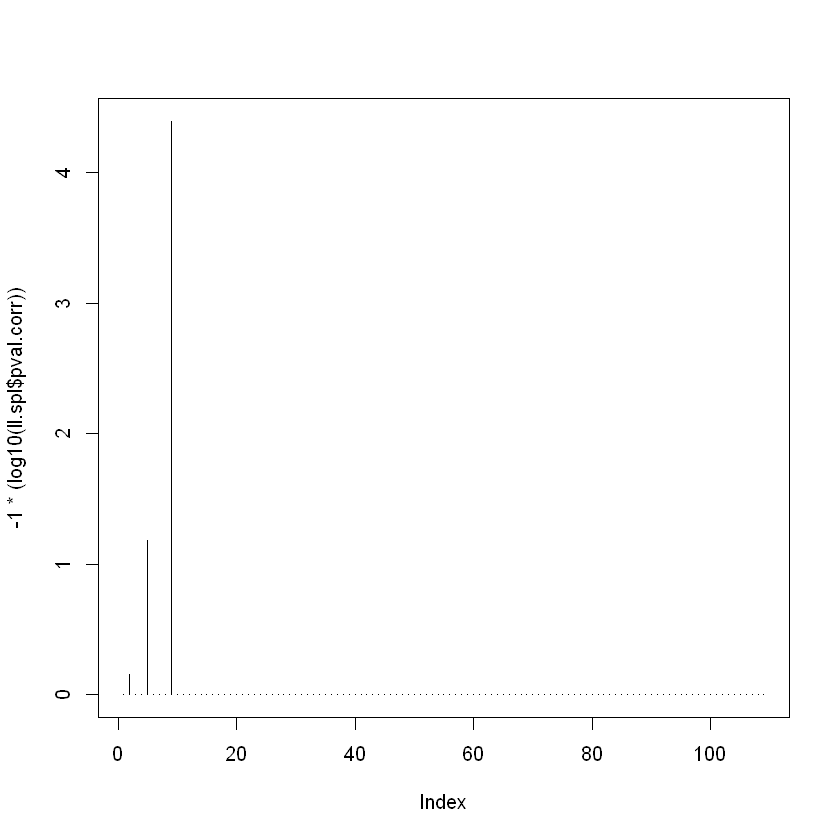

In [ ]:
plot(-1*(log10(ll.spl$pval.corr)),type="h")
(names(SA2)[-10])[ll.spl$pval.corr<0.05]

In class we also talked about various de-sparsifying/de-biasing approaches for obtaining p-values features selection in a high-dimensional setting. Here are some runs with the methods that were presented in the lectures.

In [ ]:
ll<-lasso.proj(x=as.matrix(SA2[,-10]), y=SA2[,10], family="binomial")

Nodewise regressions will be computed as no argument Z was provided.

You can store Z to avoid the majority of the computation next time around.

Z only depends on the design matrix x.

Warning message in warning.sigma.message():
"Overriding the error variance estimate with your own value. The initial estimate implies an error variance estimate and if they don't correspond the testing might not be correct anymore."


[1] "tobacco" "famhist" "age"

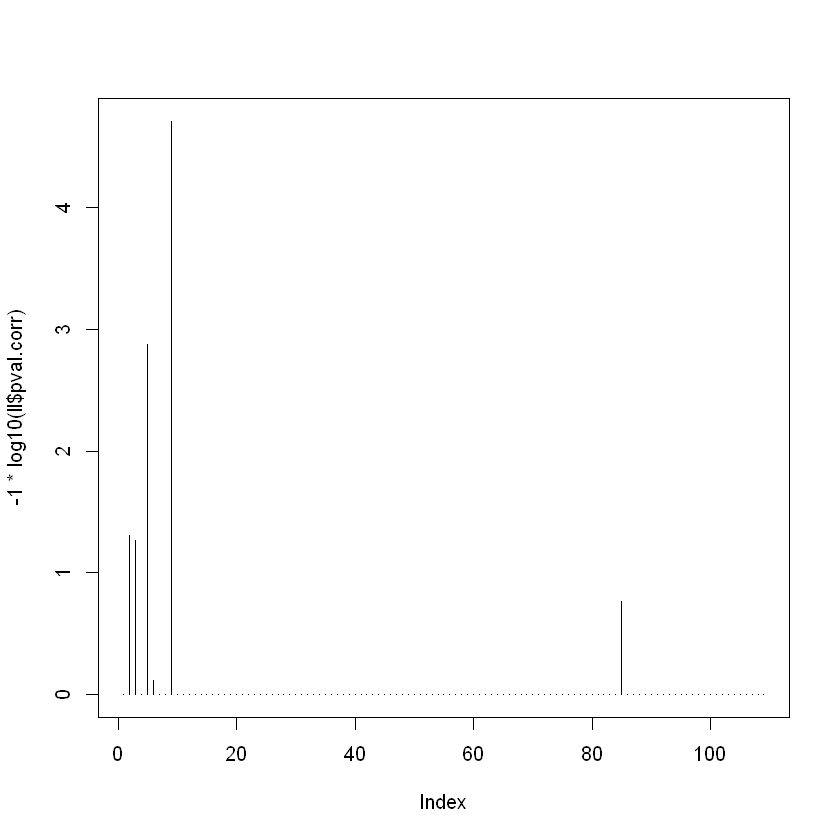

In [ ]:
plot(-1*log10(ll$pval.corr),type="h")
(names(SA2)[-10])[ll$pval.corr<0.05]

In [ ]:
rr<-ridge.proj(x=as.matrix(SA2[,-10]), y=SA2[,10], family="binomial")

Warning message in warning.sigma.message():
"Overriding the error variance estimate with your own value. The initial estimate implies an error variance estimate and if they don't correspond the testing might not be correct anymore."


[1] "age"

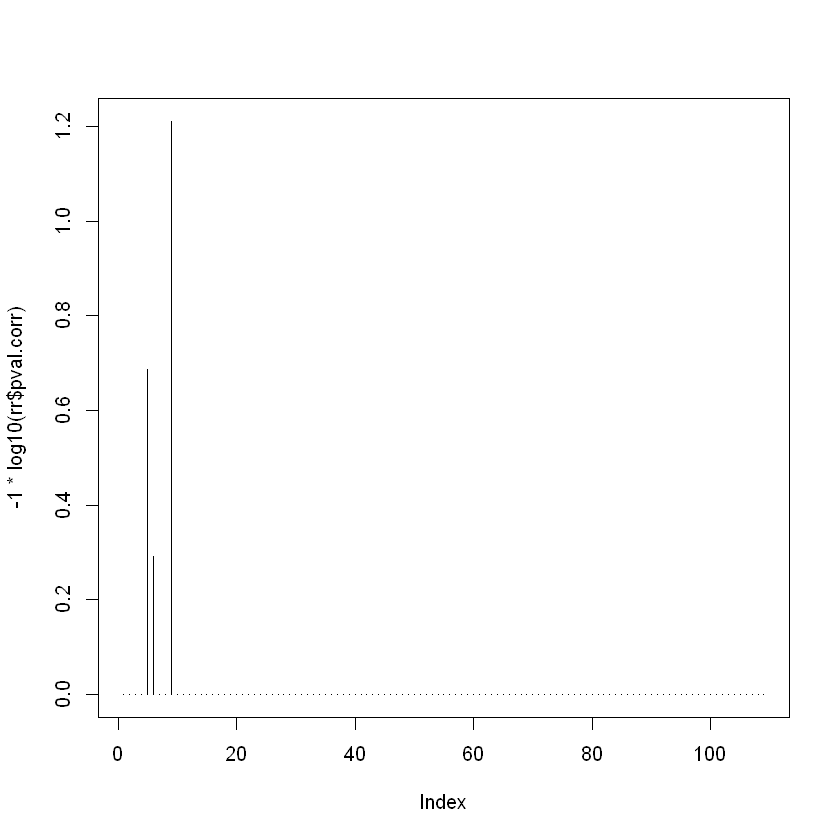

In [ ]:
plot(-1*log10(rr$pval.corr),type="h")
(names(SA2)[-10])[rr$pval.corr<0.1]

These procedures select very few features for this data set, on par with the stability selection controling the false positives at around 1-5. This is because the default is using FWER controlling procedures. You can change this to e.g. BH if you want.

Nodewise regressions will be computed as no argument Z was provided.

You can store Z to avoid the majority of the computation next time around.

Z only depends on the design matrix x.

Warning message in warning.sigma.message():
"Overriding the error variance estimate with your own value. The initial estimate implies an error variance estimate and if they don't correspond the testing might not be correct anymore."


[1] "tobacco" "ldl"     "famhist" "age"     "X76"

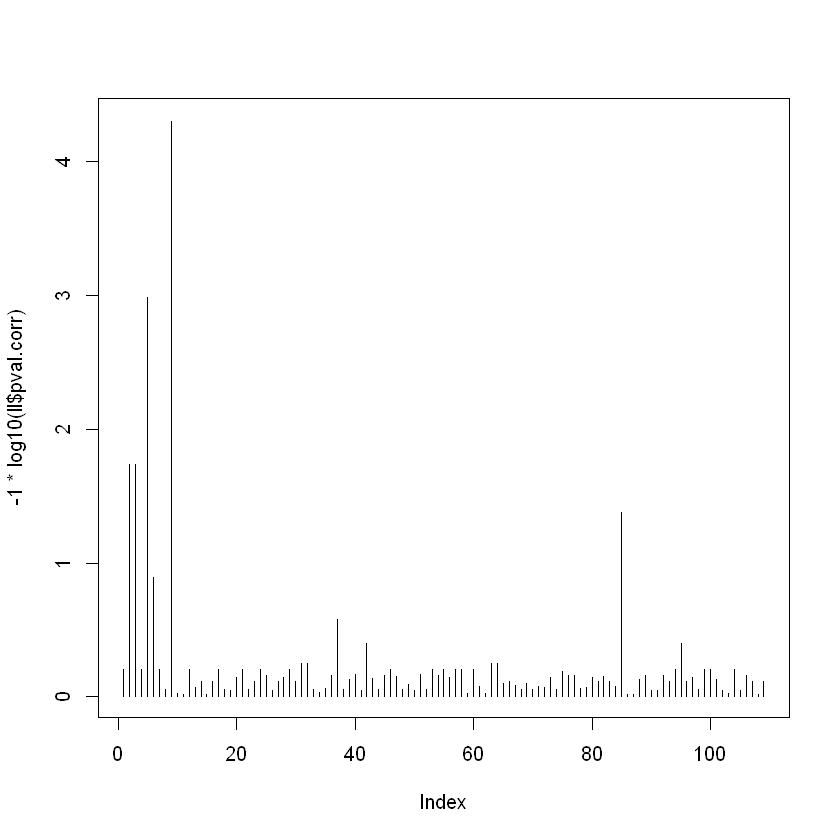

In [ ]:
ll<-lasso.proj(x=as.matrix(SA2[,-10]), y=SA2[,10], family="binomial", multiplecorr.method="BH")
plot(-1*log10(ll$pval.corr),type="h")
(names(SA2)[-10])[ll$pval.corr<0.05]

In the 'hdi' package we can also test groups of features. For the expanded heart disease data we get the following result. You see that the groups are refined top-to-bottom and in the end the selected results agree quite well the above findings (famhist and age are the strongest selected predictors). Age is correlated with a lot of the other features so they are grouped with this feature in the tests. famhist is not grouped with any of the original predictors.

I first run the cluster test on the original data without extra noise feature to illustrate. You see that age and all but the famhist variable cluster together.

Nodewise regressions will be computed as no argument Z was provided.

You can store Z to avoid the majority of the computation next time around.

Z only depends on the design matrix x.

Warning message in warning.sigma.message():
"Overriding the error variance estimate with your own value. The initial estimate implies an error variance estimate and if they don't correspond the testing might not be correct anymore."


[1] "tobacco" "ldl"     "famhist" "typea"   "age"

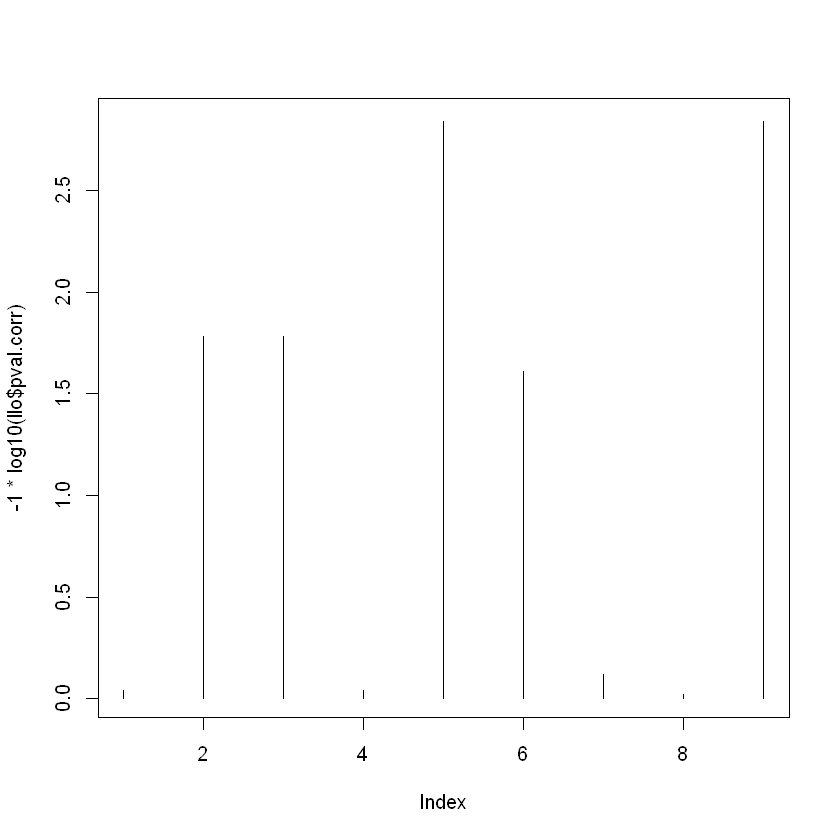

0.0014,"1, 2, 3, 4, 5, 6, 7, 8, 9"
0.0016,"1, 2, 3, 4, 6, 7, 8, 9"
0.0014,5
0.0016,"1, 2, 3, 4, 6, 7, 9"
0.0016,"1, 2, 3, 4, 7, 9"
0.0016,"1, 2, 9"
0.0016,"2, 9"
0.0016,9


[1] "clusters"   "pval"       "leftChild"  "rightChild" "alpha"     
[6] "hh"         "method"

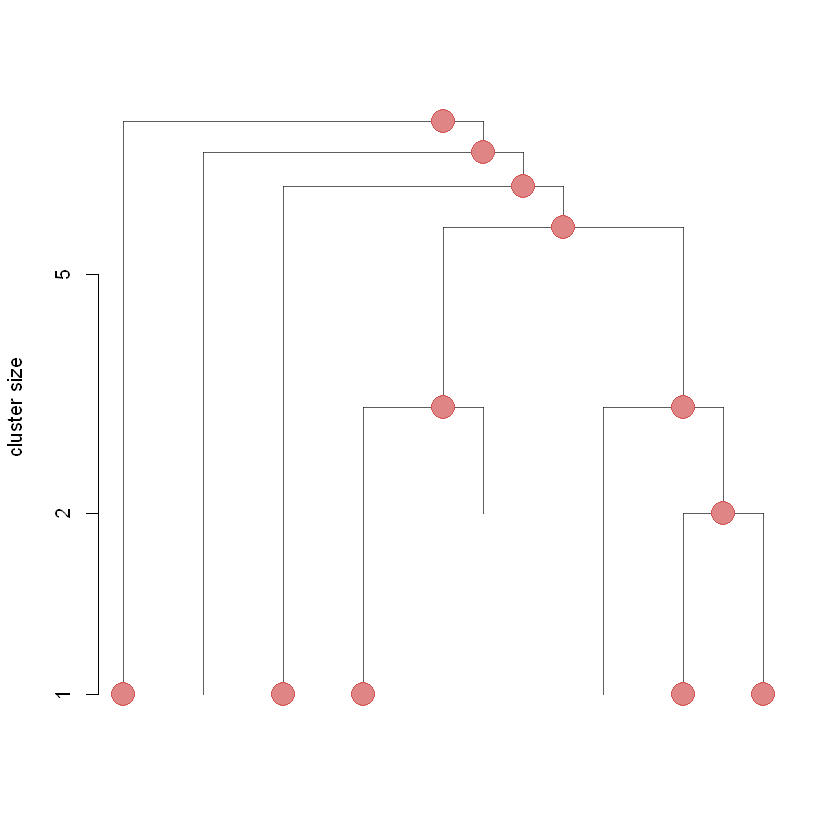

In [ ]:
llo<-lasso.proj(x=as.matrix(SA[,-10]), y=SA[,10], family="binomial")
plot(-1*log10(llo$pval.corr),type="h")
(names(SA)[-10])[llo$pval.corr<0.05]
cco<-llo$clusterGroupTest()
plot(cco)
cbind(round(cco$pval[cco$pval<0.01],4),cco$clusters[cco$pval<0.01])
names(cco)

Let's now try this on the data with noise features.

0,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109"
0,"1, 2, 3, 4, 7, 9, 16, 17, 28, 29, 32, 43, 54, 56, 59, 68, 69, 78, 85, 88, 92, 95, 96, 98, 99, 101, 104, 108"
0.0021,"5, 6, 8, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 86, 87, 89, 90, 91, 93, 94, 97, 100, 102, 103, 105, 106, 107, 109"
0.0021,"5, 8, 10, 11, 20, 21, 24, 25, 41, 49, 57, 62, 63, 76, 83, 94"
0,"1, 2, 3, 4, 7, 9, 17, 28, 29, 32, 43, 88, 96, 101, 104, 108"
0.0021,"5, 8, 20, 21, 24, 57, 62, 63, 76, 83, 94"
0,"1, 2, 3, 4, 7, 9, 28, 43, 88, 96, 101, 104, 108"
0.0021,"5, 20, 24, 57, 83, 94"
0,"1, 2, 3, 4, 7, 9, 28, 88, 96, 101, 108"
0,"1, 2, 3, 4, 7, 9, 28, 96, 101"
0,"1, 2, 3, 4, 7, 9"


[1] "clusters"   "pval"       "leftChild"  "rightChild" "alpha"     
[6] "hh"         "method"

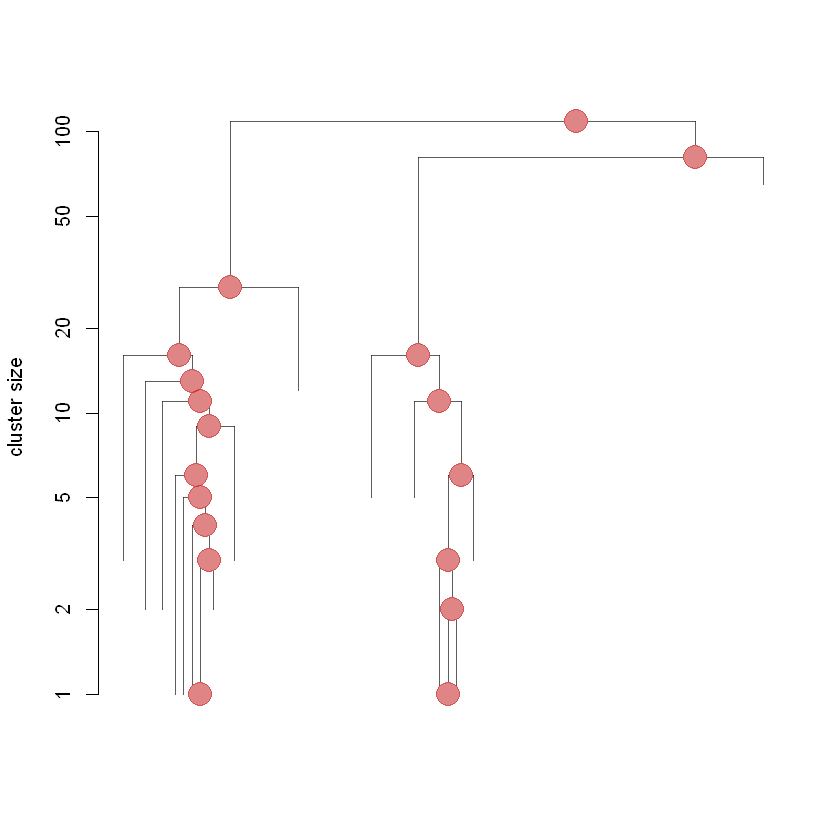

In [ ]:
cc<-ll$clusterGroupTest()
plot(cc)
cbind(round(cc$pval[cc$pval<0.01],4),cc$clusters[cc$pval<0.01])
names(cc)

To demonstrate the clustering, I add an additional feature strongly correlated with age and rerun the above steps.

Nodewise regressions will be computed as no argument Z was provided.

You can store Z to avoid the majority of the computation next time around.

Z only depends on the design matrix x.

Warning message in warning.sigma.message():
"Overriding the error variance estimate with your own value. The initial estimate implies an error variance estimate and if they don't correspond the testing might not be correct anymore."


[1] "tobacco" "ldl"     "famhist" "age"     "X76"

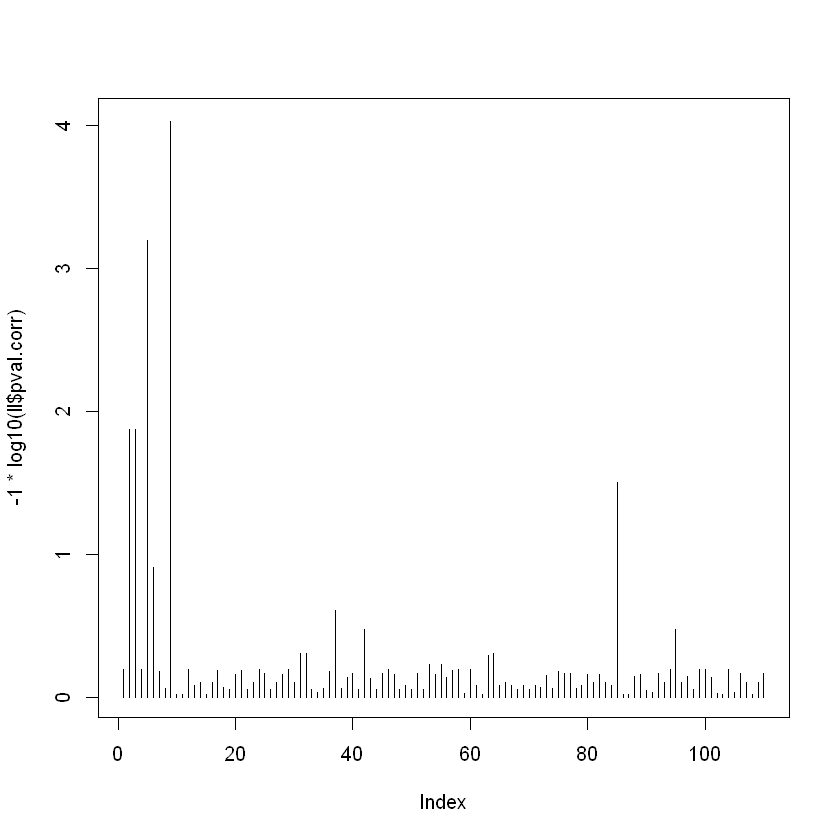

In [ ]:
SA3 <- SA2
SA3 <- data.frame(cbind(SA3, SA3$age+rnorm(dim(SA3)[1],sd=.25)))
names(SA3)<-c(names(SA2),"ageX")
ll<-lasso.proj(x=as.matrix(SA3[,-10]), y=SA3[,10], family="binomial", multiplecorr.method="BH")
plot(-1*log10(ll$pval.corr),type="h")
(names(SA3)[-10])[ll$pval.corr<0.1]

1e-04,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110"
1e-04,"1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16, 17, 18, 20, 21, 22, 24, 25, 28, 29, 32, 33, 37, 41, 43, 46, 51, 53, 54, 56, 57, 59, 62, 63, 68, 69, 76, 78, 83, 85, 88, 92, 93, 94, 95, 96, 98, 99, 101, 104, 108, 110"
1e-04,"1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16, 17, 18, 20, 21, 22, 24, 25, 28, 29, 32, 33, 37, 41, 43, 46, 51, 53, 54, 57, 62, 63, 76, 83, 88, 92, 93, 94, 95, 96, 98, 101, 104, 108, 110"
1e-04,"1, 2, 3, 4, 7, 9, 15, 17, 18, 28, 29, 32, 33, 37, 43, 51, 63, 76, 88, 96, 101, 104, 108, 110"
0.0013,"5, 8, 10, 16, 20, 21, 22, 24, 25, 41, 46, 53, 54, 57, 62, 83, 92, 93, 94, 95, 98"
1e-04,"1, 2, 3, 4, 7, 9, 17, 28, 29, 32, 43, 51, 96, 101, 104, 110"
0.0013,"5, 8, 10, 21, 24, 25, 41, 53, 62, 94"
1e-04,"1, 2, 3, 4, 7, 9, 28, 43, 51, 96, 101, 104, 110"
0.0013,"5, 8, 21, 24, 94"
1e-04,"1, 2, 3, 4, 7, 9, 28, 51, 96, 101, 110"
1e-04,"1, 2, 3, 4, 7, 9, 51, 110"


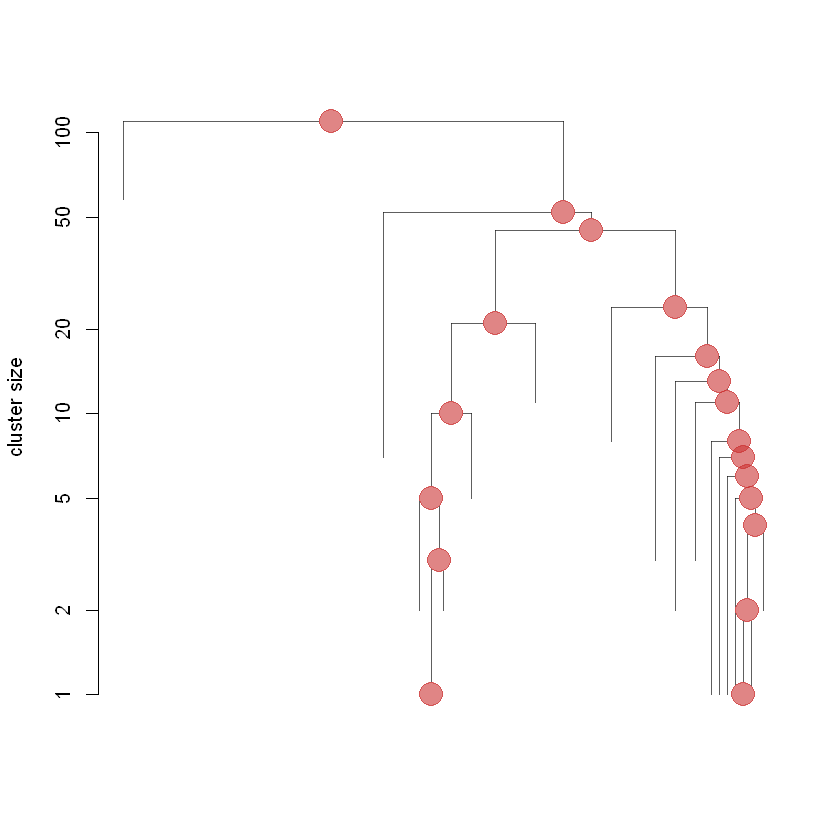

In [ ]:
cc<-ll$clusterGroupTest()
plot(cc)
cbind(round(cc$pval[cc$pval<0.01],4),cc$clusters[cc$pval<0.01])

Finally, let's just apply the multiple testing procedures to the raw p-values from the full fit. Note - we can do so here because $n>p$, otherwise we would *have* to use the methods above. 

In [ ]:
gfull <- glm(chd~., data=SA2, family="binomial")
summary(gfull)


Call:
glm(formula = chd ~ ., family = "binomial", data = SA2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8298  -0.5463  -0.1066   0.4523   3.1718  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.529217   0.219342  -6.972 3.13e-12 ***
sbp         -0.028252   0.178430  -0.158 0.874191    
tobacco      0.673721   0.204368   3.297 0.000979 ***
ldl          0.546916   0.198251   2.759 0.005803 ** 
adiposity    0.519484   0.402818   1.290 0.197181    
famhist      0.722424   0.181893   3.972 7.14e-05 ***
typea        0.734458   0.196421   3.739 0.000185 ***
obesity     -0.654055   0.319224  -2.049 0.040473 *  
alcohol     -0.176324   0.171674  -1.027 0.304381    
age          1.243205   0.299210   4.155 3.25e-05 ***
X1          -0.050684   0.166666  -0.304 0.761050    
X2           0.099159   0.185870   0.533 0.593697    
X3          -0.054176   0.173620  -0.312 0.755013    
X4          -0.052705   0.181791  -0.290 0.771875   

In [ ]:
library(multtest) # a library in R with many different p-value adjustment methods
praw<-summary(gfull)$coef[-1,4]
padjBH<-p.adjust(praw, method="BH") 
padjBonf<-p.adjust(praw, method="bonferroni") 
print(c("Selected from raw p-values: "))
      (names(SA2)[-10])[praw<0.05]
print(c("Bonferroni selection: "))
      (names(SA2)[-10])[padjBonf<0.05]
print(c("Selected with FDR<0.05 control: "))
      (names(SA2)[-10])[padjBH<0.05]




Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.




[1] "Selected from raw p-values: "


[1] "tobacco" "ldl"     "famhist" "typea"   "obesity" "age"     "X5"     
 [8] "X12"     "X15"     "X18"     "X22"     "X28"     "X37"     "X46"    
[15] "X48"     "X51"     "X54"     "X55"     "X64"     "X65"     "X67"    
[22] "X76"     "X84"     "X85"     "X86"     "X89"     "X95"

[1] "Bonferroni selection: "


[1] "famhist" "typea"   "age"

[1] "Selected with FDR<0.05 control: "


[1] "tobacco" "famhist" "typea"   "age"     "X48"

### Summary ###

If $n<p$ we can use regularized methods for feature selection.
- Such methods depend on tuning and may be unstable
- Explore this via resampling as an alternative selection procedure: *stability selection*
- Use de-biasing techniques to obtain p-values
- Remember to correct for multiple testing